Code for examining how HMM performs under different perturbations to population activity. 

Tests recalibration performance in response to mean shifts, PD shifts

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression


import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/MATLAB/')
sys.path.append('../utils/simulation/')
from plotting_utils import figSize
from HMM_matlab import hmmviterbi_vonmises, hmmdecode_vonmises
from simulation_matlab import *
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [7]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 1
nTrainingSteps = 10000

tuning         = generateUnits(n_units = nUnits, SNR = SNR)

calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(tuning[:,1:].T)  + tuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(tuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(tuning[:, 2])

In [ ]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(tuning, D,alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [ ]:
# general settings:
nSimSteps    = 100000
n_sessions   = 10
days_between = 1

# HMM settings:
vmKappa    = 2          # Precision parameter for the von mises distribution
probThresh = 0.4
gridSize   = 20
stayProb   = 0.9999


#-----------------------------------------
session_scores = np.zeros((n_sessions + 1, 2)) # 0: no recalibration, 1: HMM recalibration, 2: full recalibration

nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)


# Day 0 performance:
ttt                  = simulateBCIFitts(tuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] n
session_scores[0, :] = np.mean(ttt)

#eng       = matlab.engine.start_matlab()

D_HMM = np.copy(D)
for i in range(n_session):
    
    for j in range(days_between + 1):
        tuning = simulateTuningShift(tuning, PD_ratio = PD_ratio, mean_shift = 0)  # introduce daily nonstationarities between recorded sessions
    
    # No recalibration:
    cursorPos, _, decOut, _, _, neural, _, ttt_new = simulateBCIFitts(tuning, D, alpha, beta, nDelaySteps, delT, nSimSteps) 
    session_scores[i+1, 0]                         = np.mean(ttt_new)

    # HMM recalibration:
    targStates, logP = hmmviterbi_vonmises(D_HMM, stateTrans, targLocs, cursorPos, pStateStart, vmKappa)
    pTargState, pSeq = hmmdecode_vonmises(D_HMM,  stateTrans, targLocs, cursorPos, pStateStart, vmKappa)
    
    inferredTargLoc  = targLocs[targStates.astype('int').flatten() - 1,:]
    inferredPosErr   = inferredTargLoc - cursorPos

    D_HMM          = np.linalg.lstsq(np.hstack([np.ones((neural.shape[0], 1)), neural]), inferredPosErr, rcond = -1)[0]
    decVec_new     = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_new)

    #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
    #This will restore the original optimal gain.
    inferredTargDist = np.linalg.norm(inferredPosErr, axis = 1)
    inferredTargDir  = inferredPosErr / inferredTargDist[:, np.newaxis]
    farIdx           = np.where(inferredTargDist > 0.4)[0]
    projVec          = np.sum(np.multiply(decVec_new[farIdx, :], inferredTargDir[farIdx, :]), axis = 1)
    D_HMM           /= np.mean(projVec)


    ttt_HMMrecal            = simulateBCIFitts(newTuning, D_new, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
    session_scores[i+1, 1]  = np.mean(ttt_HHMrecal)


    


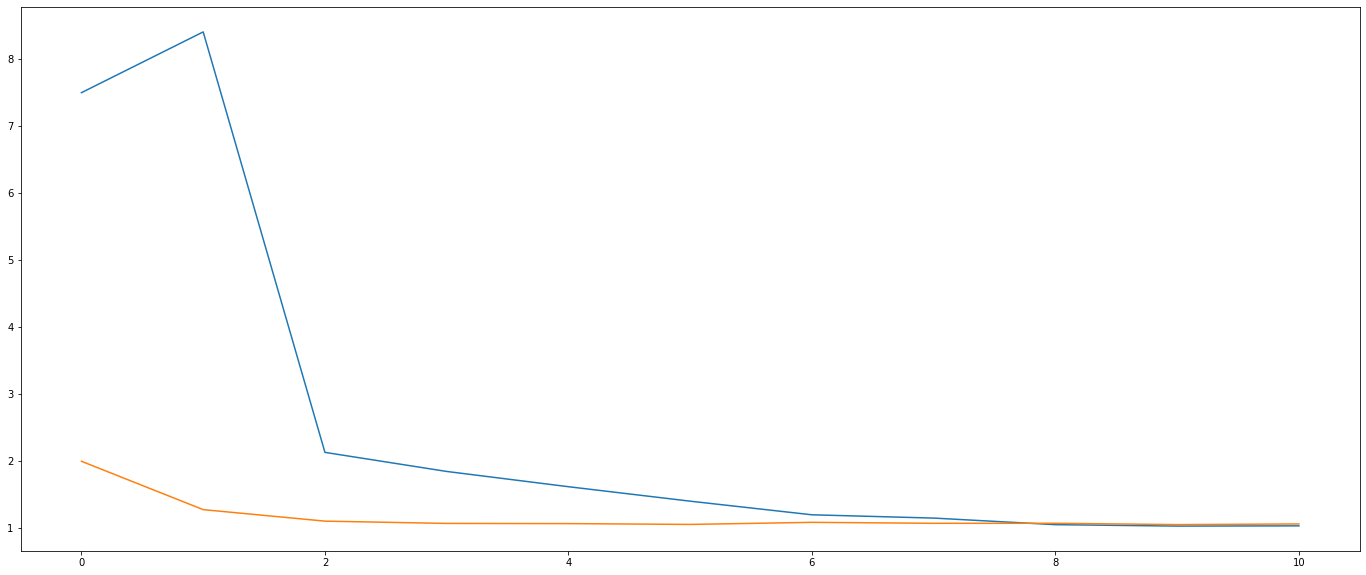

In [167]:
plt.plot(sweep_scores[:, 0, 0])
plt.plot(sweep_scores[:, 0, 1])